# Pneuomonia Recognition

Il nostro obiettivo è riuscire a classificare immagini di radiografie del torace in base alla presenza o assenza di polmonite.
Per eseguire questo task proveremo due diversi classificatori:
* Alberi decisionali
* Convolutional Neural Networks

In [24]:
import numpy as np
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

Visualizziamo alcune immagini del dataset, target pari ad uno indicano un caso di Polmonite, 0 indica assenza di Polmonite

In [25]:
print("Number of images:", X.shape[0])
positive = 0
negative = 0

for i in range(X.shape[0]):
    if(y[i]==1):
        positive += 1
    if(y[i]==0):
        negative += 1

print("Number of positive cases:", positive)
print("Number of negative cases:", negative)

Number of images: 5232
Number of positive cases: 3883
Number of negative cases: 1349


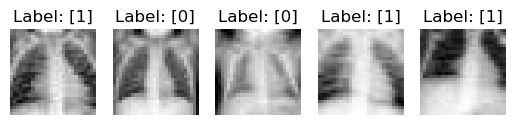

In [26]:
import matplotlib.pyplot as plt


# Visualizza alcune immagini
num_images_to_display = 5

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X))
    image = X[index]
    label = y[index]

    # Visualizza l'immagine con la sua etichetta
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Il dataset è sbilanciato verso le immagini con polmonite:

Circa il 74.2% delle immagini rappresentano casi di polmonite.
Circa il 25.8% delle immagini rappresentano casi negativi.

Andiamo a suddividere il train set tra training e test, utilizzando stratify per mantenere proporzione tra le classi

In [27]:
from sklearn.model_selection import train_test_split

# Suddivisione in set di addestramento e set di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A questo punto andiamo a dividere il Training Set in Training e Validation, mantenendo la stessa proporzione

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [29]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_valid.reshape(X_valid.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

Vado a normalizzare i dati dopo aver suddiviso Training, Validation e Test per evitare Data Leakage

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_normalized = scaler.transform(X_val_reshaped).reshape(X_valid.shape)
X_test_normalized = scaler.transform(X_test_reshaped).reshape(X_test.shape)

In [32]:
print(f'Original X_train shape: {X_train.shape}')
print(f'Normalized X_train shape: {X_train_normalized.shape}')

print(f'Original X_val shape: {X_valid.shape}')
print(f'Normalized X_val shape: {X_val_normalized.shape}')

print(f'Original X_test shape: {X_test.shape}')
print(f'Normalized X_test shape: {X_test_normalized.shape}')

Original X_train shape: (3348, 28, 28)
Normalized X_train shape: (3348, 28, 28)
Original X_val shape: (837, 28, 28)
Normalized X_val shape: (837, 28, 28)
Original X_test shape: (1047, 28, 28)
Normalized X_test shape: (1047, 28, 28)


Essendo le classi sbilanciate, preferiamo una metrica come F1 rispetto ad Accuracy

In [33]:
from tensorflow.keras import backend as K

# Funzione per calcolare l'F1-score
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

Definiamo una funzione per la stampa dei vari grafici

In [34]:
import matplotlib.pyplot as plt

def graphics(history):
    plt.figure(figsize=(12, 4))

    # Plot della perdita
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle metriche
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['f1_score'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

## Alberi decisionali

Cominciamo con un semplice Albero Decisionale, vado quindi ad appiattire i miei dati e usiamo Ravel sui target per trasformarli in vettori 1D

In [90]:
X_train_flatten = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_val_flatten = X_val_normalized.reshape(X_val_normalized.shape[0], -1)
X_test_flatten = X_test_normalized.reshape(X_test_normalized.shape[0], -1)
y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()
print(f"Flattened training set size: {X_train_flatten.shape}")
print(f"Flattened validation set size: {X_val_flatten.shape}")
print(f"Flattened test set size: {X_test_flatten.shape}")
print(f"Train set label size: {y_train.shape}")
print(f"Validation set label size: {y_valid.shape}")
print(f"Test set label size: {y_test.shape}")

Flattened training set size: (3348, 784)
Flattened validation set size: (837, 784)
Flattened test set size: (1047, 784)
Train set label size: (3348,)
Validation set label size: (837,)
Test set label size: (1047,)


In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Creazione dell'albero decisionale
clf = DecisionTreeClassifier()

# Addestramento del modello
clf.fit(X_train_flatten, y_train)

DecisionTreeClassifier()

In [92]:
# Previsioni
y_val_pred = clf.predict(X_val_flatten)
val_accuracy = accuracy_score(y_valid, y_val_pred)
val_f1 = f1_score(y_valid, y_val_pred, average='weighted')  # Calcolo F1 sul set di validazione

In [93]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Accuracy: 0.8996
Validation F1 Score: 0.8985


###Random Forest
Per migliorare l'accuratezza del modello, proviamo l'uso di Random Forest, applichiamo quindi la tecnica del Bagging sugli alberi decisionali.

In [94]:
from sklearn.ensemble import RandomForestClassifier

randomFC = RandomForestClassifier(n_estimators=100, random_state=42)
randomFC.fit(X_train_flatten, y_train)

RandomForestClassifier(random_state=42)

In [95]:
# Previsioni
y_val_pred = randomFC.predict(X_val_flatten)
val_accuracy = accuracy_score(y_valid, y_val_pred)
val_f1 = f1_score(y_valid, y_val_pred, average='weighted')  # Calcolo F1 sul set di validazione

In [96]:
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Accuracy: 0.9438
Validation F1 Score: 0.9434


###RandomizedSearchCV

Usare GridSearch per trovare i migliori parametri su Random Forest richiede una quantità di tempo troppo elevata, usiamo quindi RandomizedSearchCV che va a campionare un numero fissato di impostazioni dei parametri da una distribuzione di probabilità piuttosto che cercare ogni combinazione possibile.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

randomFCRSRS = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

random_search = RandomizedSearchCV(estimator=randomFCRSRS, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_flatten, y_train)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

In [12]:
X_train_expand = np.expand_dims(X_train_normalized, axis=-1)
X_val_expand = np.expand_dims(X_val_normalized, axis=-1)
X_test_expand = np.expand_dims(X_test_normalized, axis=-1)

In [14]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [15]:
# Stampa una rappresentazione del modello
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [16]:
# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [17]:
history = cnn1.fit(X_train_expand, y_train, epochs=50, batch_size=32, validation_data=(X_val_expand, y_valid))

Epoch 1/50
105/105 [==============================] - 7s 48ms/step - loss: 0.3302 - accuracy: 0.8492 - f1_score: 0.9063 - val_loss: 0.2072 - val_accuracy: 0.9104 - val_f1_score: 0.9350
Epoch 2/50
105/105 [==============================] - 2s 18ms/step - loss: 0.1705 - accuracy: 0.9325 - f1_score: 0.9531 - val_loss: 0.2061 - val_accuracy: 0.9116 - val_f1_score: 0.9325
Epoch 3/50
105/105 [==============================] - 2s 18ms/step - loss: 0.1508 - accuracy: 0.9403 - f1_score: 0.9580 - val_loss: 0.1594 - val_accuracy: 0.9367 - val_f1_score: 0.9515
Epoch 4/50
105/105 [==============================] - 4s 41ms/step - loss: 0.1303 - accuracy: 0.9480 - f1_score: 0.9642 - val_loss: 0.1458 - val_accuracy: 0.9427 - val_f1_score: 0.9554
Epoch 5/50
105/105 [==============================] - 4s 34ms/step - loss: 0.1206 - accuracy: 0.9564 - f1_score: 0.9700 - val_loss: 0.1268 - val_accuracy: 0.9510 - val_f1_score: 0.9627
Epoch 6/50
105/105 [==============================] - 4s 41ms/step - loss: 

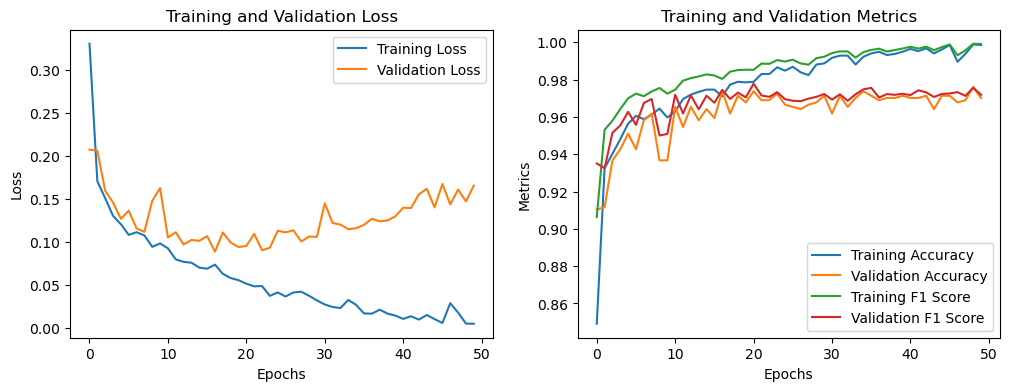

In [18]:
graphics(history)

27/27 [==============================] - 0s 2ms/step


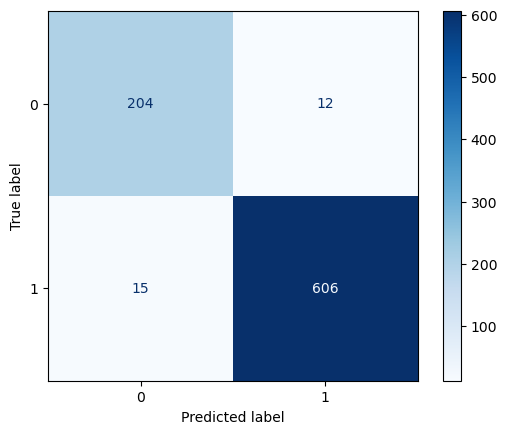

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = cnn1.predict(X_val_normalized)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
test_loss, test_accuracy = cnn1.evaluate(X_test_normalized, y_test, batch_size=32)
print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")

SyntaxError: invalid syntax (1484095021.py, line 3)

Il modello, dalla curva riguardante la Validation Loss, mostra Overfitting, vista la dimensione ridotta del training set, applichiamo data Augmentation per renderlo più corposo. Per immagini mediche non è raccomandato l'uso di flip orizzontali, evitiamo quindi il suo utilizzo tra le possibili variazioni.

In [21]:
X_train_expand = np.expand_dims(X_train_normalized, axis=-1)
X_val_expand = np.expand_dims(X_val_normalized, axis=-1)
X_test_expand = np.expand_dims(X_test_normalized, axis=-1)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,  # Non riflettere lungo l'asse x per immagini mediche
    fill_mode='nearest'
)

# Definisci il generatore di dati per il set di validazione senza data augmentation
val_datagen = ImageDataGenerator()

# Assicurati di adattare i generatori ai tuoi dati
train_generator = train_datagen.flow(X_train_expand, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_expand, y_valid, batch_size=32)

Andiamo a vedere un paragone tra le immagini reali, e le immagini generate tramite il generatore.

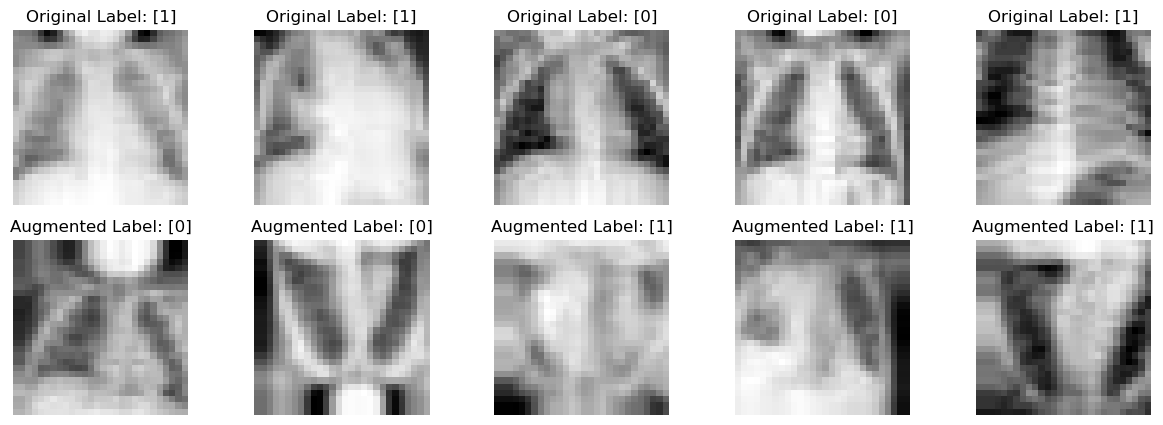

In [23]:
# Visualizza alcune immagini originali
num_images_to_display = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X_train))
    original_image = X_train[index]
    original_label = y_train[index]

    # Visualizza l'immagine originale con la sua etichetta
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Label: {original_label}")
    plt.axis('off')

# Visualizza alcune immagini generate
for i in range(num_images_to_display):
    augmented_data = next(train_generator)
    augmented_image = augmented_data[0][0]  # Ottieni l'immagine generata
    augmented_label = augmented_data[1][0]  # Ottieni l'etichetta generata

    # Visualizza l'immagine generata con la sua etichetta
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Label: {augmented_label}")
    plt.axis('off')

plt.show()

In [24]:
# Addestramento del modello con data augmentation
history2 = cnn1.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
)

Epoch 1/50
104/104 [==============================] - 7s 56ms/step - loss: 0.3173 - accuracy: 0.8839 - f1_score: 0.9207 - val_loss: 0.1424 - val_accuracy: 0.9447 - val_f1_score: 0.9613
Epoch 2/50
104/104 [==============================] - 5s 50ms/step - loss: 0.1830 - accuracy: 0.9282 - f1_score: 0.9507 - val_loss: 0.1265 - val_accuracy: 0.9507 - val_f1_score: 0.9655
Epoch 3/50
104/104 [==============================] - 4s 43ms/step - loss: 0.1573 - accuracy: 0.9367 - f1_score: 0.9569 - val_loss: 0.1295 - val_accuracy: 0.9531 - val_f1_score: 0.9671
Epoch 4/50
104/104 [==============================] - 5s 45ms/step - loss: 0.1445 - accuracy: 0.9427 - f1_score: 0.9610 - val_loss: 0.1330 - val_accuracy: 0.9447 - val_f1_score: 0.9615
Epoch 5/50
104/104 [==============================] - 4s 38ms/step - loss: 0.1318 - accuracy: 0.9454 - f1_score: 0.9623 - val_loss: 0.1380 - val_accuracy: 0.9471 - val_f1_score: 0.9627
Epoch 6/50
104/104 [==============================] - 5s 44ms/step - loss: 

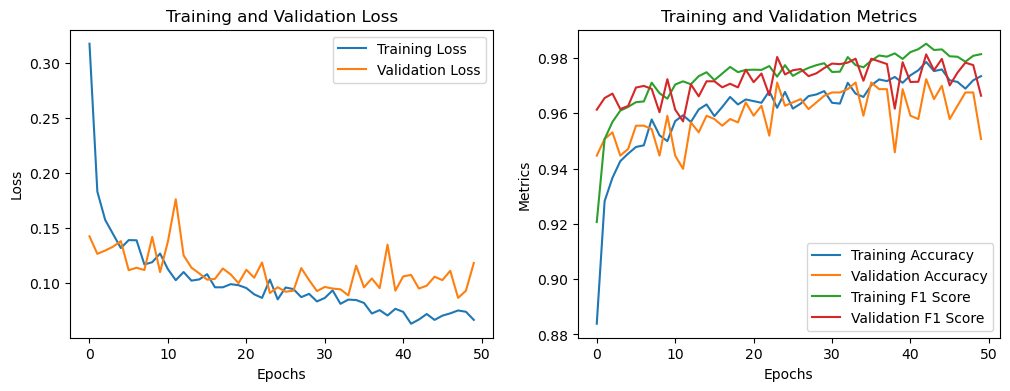

In [26]:
graphics(history2)

La curva della Validation Loss scende molto meglio, la Data Augmentation ha contribuito a diminuire l'Overfitting.
Proviamo ora un modello più performante, scegliendo un modello VGG-Like, inoltre aggiungiamo la CallBack di Early Stopping come metodo di regolarizzazione.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
cnn2 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(6, 6),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [23]:
# Compilazione del modello
cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Definizione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [36]:
# Addestramento del modello
history3 = cnn2.fit( train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping])

Epoch 1/50
104/104 [==============================] - 9s 72ms/step - loss: 0.4661 - accuracy: 0.7799 - f1_score: 0.8544 - val_loss: 0.3051 - val_accuracy: 0.8942 - val_f1_score: 0.9237
Epoch 2/50
104/104 [==============================] - 7s 66ms/step - loss: 0.3084 - accuracy: 0.8628 - f1_score: 0.9071 - val_loss: 0.2026 - val_accuracy: 0.9147 - val_f1_score: 0.9401
Epoch 3/50
104/104 [==============================] - 6s 56ms/step - loss: 0.2402 - accuracy: 0.8932 - f1_score: 0.9270 - val_loss: 0.1963 - val_accuracy: 0.9267 - val_f1_score: 0.9482
Epoch 4/50
104/104 [==============================] - 6s 56ms/step - loss: 0.2212 - accuracy: 0.9071 - f1_score: 0.9365 - val_loss: 0.2028 - val_accuracy: 0.9183 - val_f1_score: 0.9418
Epoch 5/50
104/104 [==============================] - 6s 59ms/step - loss: 0.1861 - accuracy: 0.9252 - f1_score: 0.9481 - val_loss: 0.1487 - val_accuracy: 0.9471 - val_f1_score: 0.9643
Epoch 6/50
104/104 [==============================] - 6s 59ms/step - loss: 

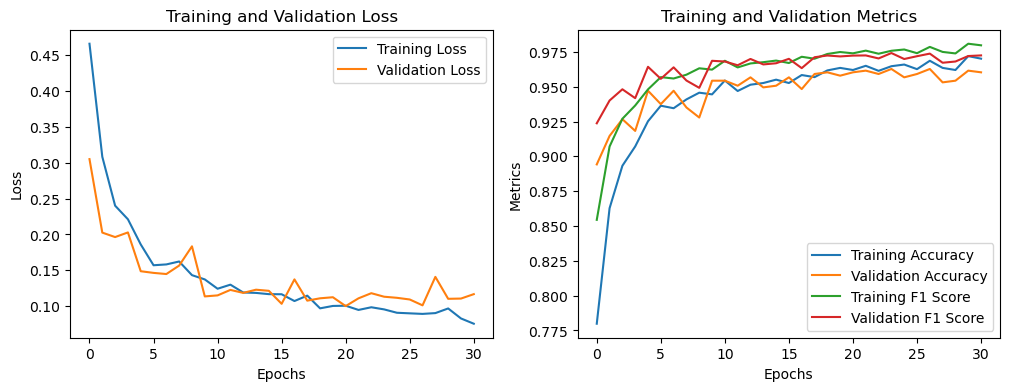

In [47]:
graphics(history3)

Introduco ora un learning rate decrescente, inizializzazione dei pesi He ed infine 

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

In [53]:
cnn2_tune = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dense(1, activation='sigmoid')
])

In [54]:
# Compilazione del modello
cnn2_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2_tune.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                      

In [55]:
history4 = cnn2_tune.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=80,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/80
104/104 [==============================] - 8s 54ms/step - loss: 1.2078 - accuracy: 0.8902 - f1_score: 0.9229 - val_loss: 1.5538 - val_accuracy: 0.7464 - val_f1_score: 0.8522 - lr: 0.0010
Epoch 2/80
104/104 [==============================] - 5s 49ms/step - loss: 0.8763 - accuracy: 0.9324 - f1_score: 0.9540 - val_loss: 0.9474 - val_accuracy: 0.8594 - val_f1_score: 0.9129 - lr: 0.0010
Epoch 3/80
104/104 [==============================] - 5s 50ms/step - loss: 0.6895 - accuracy: 0.9427 - f1_score: 0.9609 - val_loss: 0.6564 - val_accuracy: 0.9315 - val_f1_score: 0.9552 - lr: 0.0010
Epoch 4/80
104/104 [==============================] - 5s 44ms/step - loss: 0.5510 - accuracy: 0.9508 - f1_score: 0.9662 - val_loss: 0.4889 - val_accuracy: 0.9507 - val_f1_score: 0.9665 - lr: 0.0010
Epoch 5/80
104/104 [==============================] - 5s 46ms/step - loss: 0.4519 - accuracy: 0.9521 - f1_score: 0.9667 - val_loss: 0.4513 - val_accuracy: 0.9411 - val_f1_score: 0.9584 - lr: 0.0010
Epoch 6/80

Epoch 42/80
104/104 [==============================] - 6s 54ms/step - loss: 0.0940 - accuracy: 0.9861 - f1_score: 0.9903 - val_loss: 0.1404 - val_accuracy: 0.9675 - val_f1_score: 0.9778 - lr: 1.0000e-04
Epoch 43/80
104/104 [==============================] - 5s 47ms/step - loss: 0.0938 - accuracy: 0.9861 - f1_score: 0.9907 - val_loss: 0.1335 - val_accuracy: 0.9688 - val_f1_score: 0.9780 - lr: 1.0000e-04
Epoch 44/80
104/104 [==============================] - 5s 48ms/step - loss: 0.0968 - accuracy: 0.9849 - f1_score: 0.9898 - val_loss: 0.1374 - val_accuracy: 0.9663 - val_f1_score: 0.9763 - lr: 1.0000e-04
Epoch 45/80
104/104 [==============================] - 5s 49ms/step - loss: 0.0920 - accuracy: 0.9858 - f1_score: 0.9903 - val_loss: 0.1358 - val_accuracy: 0.9675 - val_f1_score: 0.9776 - lr: 1.0000e-04
Epoch 46/80
104/104 [==============================] - 6s 54ms/step - loss: 0.0904 - accuracy: 0.9858 - f1_score: 0.9904 - val_loss: 0.1365 - val_accuracy: 0.9663 - val_f1_score: 0.9769 - 

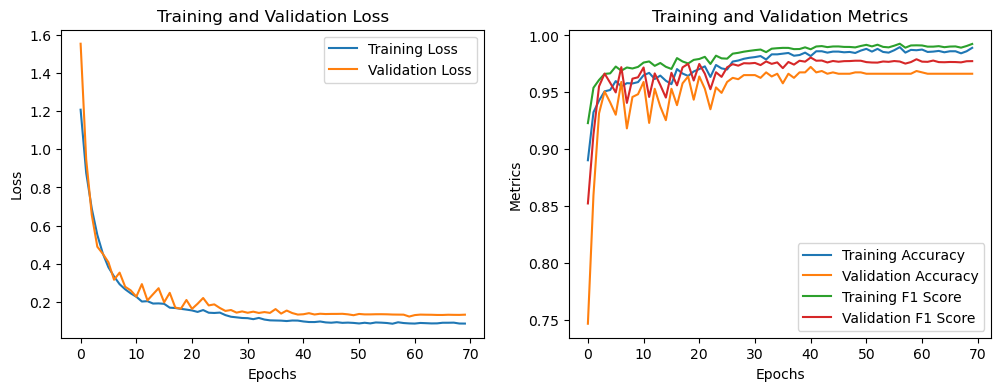

In [56]:
graphics(history4)

In [64]:
test_loss, test_accuracy, test_f1 = cnn2_tune.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9599 - f1_score: 0.9729
Loss sul set di test: 0.15693019330501556
Accuracy sul set di test: 0.9598853588104248
F1 Score sul set di test: 0.97288578748703


33/33 [==============================] - 0s 3ms/step


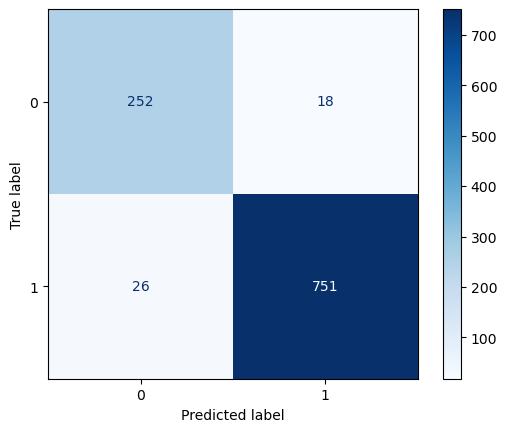

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = cnn1.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [75]:
from tensorflow.keras.layers import Dropout

In [80]:
cnn3 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [81]:
# Compilazione del modello
cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 8)         0         
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 14, 14, 16)     

In [82]:
history5 = cnn3.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/120
104/104 [==============================] - 8s 56ms/step - loss: 1.7003 - accuracy: 0.8589 - f1_score: 0.9034 - val_loss: 4.0338 - val_accuracy: 0.7404 - val_f1_score: 0.8487 - lr: 0.0010
Epoch 2/120
104/104 [==============================] - 5s 52ms/step - loss: 1.3983 - accuracy: 0.8896 - f1_score: 0.9244 - val_loss: 5.4174 - val_accuracy: 0.7428 - val_f1_score: 0.8490 - lr: 0.0010
Epoch 3/120
104/104 [==============================] - 11s 102ms/step - loss: 1.1975 - accuracy: 0.9047 - f1_score: 0.9344 - val_loss: 4.6538 - val_accuracy: 0.7440 - val_f1_score: 0.8503 - lr: 0.0010
Epoch 4/120
104/104 [==============================] - 8s 74ms/step - loss: 1.0386 - accuracy: 0.9279 - f1_score: 0.9513 - val_loss: 2.5904 - val_accuracy: 0.7452 - val_f1_score: 0.8519 - lr: 0.0010
Epoch 5/120
104/104 [==============================] - 7s 62ms/step - loss: 0.9139 - accuracy: 0.9340 - f1_score: 0.9547 - val_loss: 1.4423 - val_accuracy: 0.7969 - val_f1_score: 0.8777 - lr: 0.0010
Epo

Epoch 42/120
104/104 [==============================] - 4s 40ms/step - loss: 0.2034 - accuracy: 0.9677 - f1_score: 0.9781 - val_loss: 0.2421 - val_accuracy: 0.9531 - val_f1_score: 0.9690 - lr: 0.0010
Epoch 43/120
104/104 [==============================] - 7s 64ms/step - loss: 0.2193 - accuracy: 0.9611 - f1_score: 0.9733 - val_loss: 0.2199 - val_accuracy: 0.9627 - val_f1_score: 0.9740 - lr: 0.0010
Epoch 44/120
104/104 [==============================] - 5s 52ms/step - loss: 0.2014 - accuracy: 0.9623 - f1_score: 0.9745 - val_loss: 0.2329 - val_accuracy: 0.9555 - val_f1_score: 0.9688 - lr: 0.0010
Epoch 45/120
104/104 [==============================] - 6s 55ms/step - loss: 0.2027 - accuracy: 0.9662 - f1_score: 0.9770 - val_loss: 0.1963 - val_accuracy: 0.9639 - val_f1_score: 0.9745 - lr: 0.0010
Epoch 46/120
104/104 [==============================] - 5s 47ms/step - loss: 0.2012 - accuracy: 0.9626 - f1_score: 0.9743 - val_loss: 0.2132 - val_accuracy: 0.9471 - val_f1_score: 0.9631 - lr: 0.0010


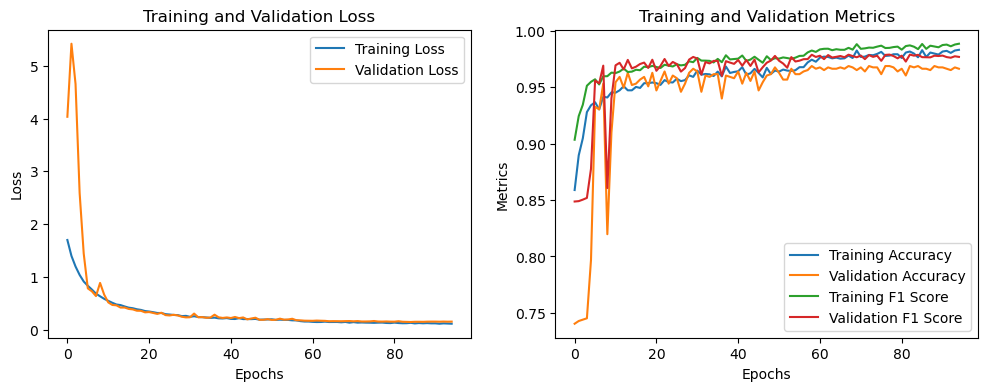

In [83]:
graphics(history5)

In [84]:
test_loss, test_accuracy, test_f1 = cnn3.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 11ms/step - loss: 0.1594 - accuracy: 0.9704 - f1_score: 0.9797
Loss sul set di test: 0.15941400825977325
Accuracy sul set di test: 0.970391571521759
F1 Score sul set di test: 0.979720413684845
